<a href="https://colab.research.google.com/github/achyutak/Projects/blob/main/Text_Generation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing dataset

In [1]:
from keras.utils.data_utils import get_file
path = get_file('shakespeare.txt',
                origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [2]:
with open(path, encoding='utf-8') as f:
  text = f.read().lower()
print('Length of Text: {} characters'.format(len(text)))

Length of Text: 1115394 characters


## Creating a list of sentences from data taken

In [3]:
print(text[:500])

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor


In [4]:
data = text[:5000]
# Taking only the first 5000 characters for building the model

In [5]:
# print(data)
# # The data we are taking to build the model.

In [6]:
# # Understanding the data
# data

In [7]:
#We see that all the lines are separated by a '\n'.
# Now we split the data into lines and create a corpus.
corpus = data.split('\n')

In [8]:
corpus[:10]

['first citizen:',
 'before we proceed any further, hear me speak.',
 '',
 'all:',
 'speak, speak.',
 '',
 'first citizen:',
 'you are all resolved rather to die than to famish?',
 '',
 'all:']

The text still has a lot of punctuation marks and blank spaces. So, we use Tokenizer from keras to remove all the unnecessary pronunciation marks and create a dictionary of most frequent words in the datset.

[Tokenizer:](https://keras.io/api/preprocessing/text/#tokenizer-class)
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

## Using Tokenizer class from tf.keras.preprocessing.text.Tokenizer

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer(num_words=500, oov_token='<OOV>') #Only the most common num_words - 1 (499 here) words are kept. 
# Any words that are not available in the vocabulary during sequence to text calls are given as <OOV>
tk.fit_on_texts(corpus)

In [10]:
# Total number of words in the corpus:
print('Total Number of words in the corpus:',len(tk.word_index))

Total Number of words in the corpus: 386


In [11]:
total_words = len(tk.word_index) + 1
print('Number of words after considering the padding:',total_words)

Number of words after considering the padding: 387


In [12]:
for line in corpus:
  tokens_list = tk.texts_to_sequences([line])[0]
  print(line)
  print(tokens_list)
  break

first citizen:
[6, 4]


In [13]:
sequences = []
for line in corpus:
  tokens_list = tk.texts_to_sequences([line])[0]
  for i in range(1,len(tokens_list)):
    sequences.append(tokens_list[:i+1]) 
# The second for loop ranges from 1 to the length of the tokens list and appends the list of sequences of variable length (2 to max_sequence_length) generated from the tokens_list 
# print(sequences)

In [14]:
max_sequence_length = max([len(x) for x in sequences])
print('Maximum length of sequences in the corpus:',max_sequence_length)

Maximum length of sequences in the corpus: 12


## Padding the sequences generated to maintain the uniformity in the dimensions.

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences,padding='pre')

In [16]:
print(padded_sequences[:5])

[[  0   0   0   0   0   0   0   0   0   0   6   4]
 [  0   0   0   0   0   0   0   0   0   0 133  10]
 [  0   0   0   0   0   0   0   0   0 133  10  71]
 [  0   0   0   0   0   0   0   0 133  10  71  72]
 [  0   0   0   0   0   0   0 133  10  71  72 134]]


In [17]:
padded_sequences.shape

(748, 12)

We take the last column in each sequence as the label and use the rest of the columns as inputs to predict the label.

## Separating the X and the y from sequences for training

In [18]:
y = padded_sequences[:,-1] #Assigns the last value in each sequence to the y
X = padded_sequences[:,:-1] #Assigns all but the last value from each sequence to X
i = 2
print(padded_sequences[i],X[i],y[i])

[  0   0   0   0   0   0   0   0   0 133  10  71] [  0   0   0   0   0   0   0   0   0 133  10] 71


In [19]:
print(type(padded_sequences),type(X),type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [20]:
max(y) #There are 386 tokens in the dictionary that were generated from the corpus

386

Here, we encode the labels (Just 'y') using one-hot encoding for easier training of ML Model.

## Using to_categorical from keras to one-hot-encode the labels.

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
Y = to_categorical(y)

In [23]:
print('After one hot encoding, the final shapes of the inputs and labels are:\nX(inputs)\t:\t{}\nY(labels)\t:\t{}'.format(X.shape,Y.shape))

After one hot encoding, the final shapes of the inputs and labels are:
X(inputs)	:	(748, 11)
Y(labels)	:	(748, 387)


## Building the model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

In [25]:
model = Sequential()
model.add(Embedding(total_words,16,input_length=X.shape[1],mask_zero=True)) 
#Since we have already pre-padded the sequences with 0, mask_zero must be kept True or else, the Embedding layer will consider the 0 as input.
model.add(LSTM(64))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(Y.shape[1],activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 16)            6192      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 387)               9

In [26]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
epochs = 500
batch_size = 256
history = model.fit(X,Y,epochs=epochs,batch_size = batch_size,validation_split=0.1)

Epoch 1/500
3/3 [==============================] - 5s 657ms/step - loss: 5.9580 - accuracy: 0.0106 - val_loss: 5.9560 - val_accuracy: 0.0800
Epoch 2/500
3/3 [==============================] - 0s 45ms/step - loss: 5.9533 - accuracy: 0.0445 - val_loss: 5.9527 - val_accuracy: 0.0800
Epoch 3/500
3/3 [==============================] - 0s 47ms/step - loss: 5.9471 - accuracy: 0.0431 - val_loss: 5.9483 - val_accuracy: 0.0800
Epoch 4/500
3/3 [==============================] - 0s 47ms/step - loss: 5.9376 - accuracy: 0.0470 - val_loss: 5.9417 - val_accuracy: 0.0800
Epoch 5/500
3/3 [==============================] - 0s 49ms/step - loss: 5.9223 - accuracy: 0.0443 - val_loss: 5.9323 - val_accuracy: 0.0800
Epoch 6/500
3/3 [==============================] - 0s 51ms/step - loss: 5.8985 - accuracy: 0.0480 - val_loss: 5.9189 - val_accuracy: 0.0800
Epoch 7/500
3/3 [==============================] - 0s 48ms/step - loss: 5.8611 - accuracy: 0.0514 - val_loss: 5.9008 - val_accuracy: 0.0800
Epoch 8/500
3/3 [==

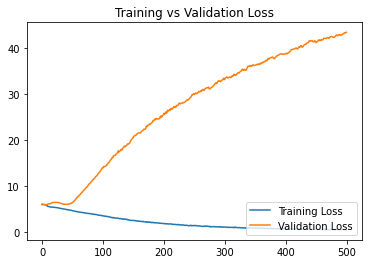

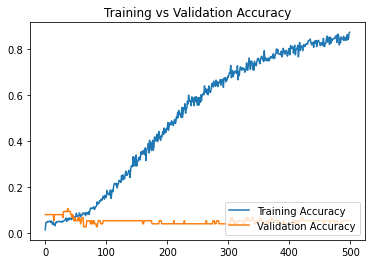

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_model(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training vs Validation Loss')
  plt.legend(['Training Loss','Validation Loss'],loc='lower right')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training vs Validation Accuracy')
  plt.legend(['Training Accuracy','Validation Accuracy'],loc='lower right')
  plt.show()
    
plot_model(history)

In [34]:
seed_text = "I'm suffering in this dearth"
next_words = 50

for _ in range(next_words):
    # Create a token lists using tokenizer text sequences of the seed text
    token_list = tk.texts_to_sequences([seed_text])[0]
    
    # Pre-pad the token list with the length of max_sequence_length-1
    token_list_padded = pad_sequences([token_list], maxlen= max_sequence_length-1, padding= 'pre')
    
    # Predict the classe for the given token list 
    predicted = model.predict_classes(token_list_padded, verbose=0)

    # Turn the token back into a word and add that to the seed text
    output_word = ""
    for word, index in tk.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I'm suffering in this dearth you may as well country he he did did did to price covetous where be go you i pray you not not barren of accusations accusations did covetous you he that fathers fathers please our himself please remain remain remain remain good to good you way for you that poor
